# Mask Detection 

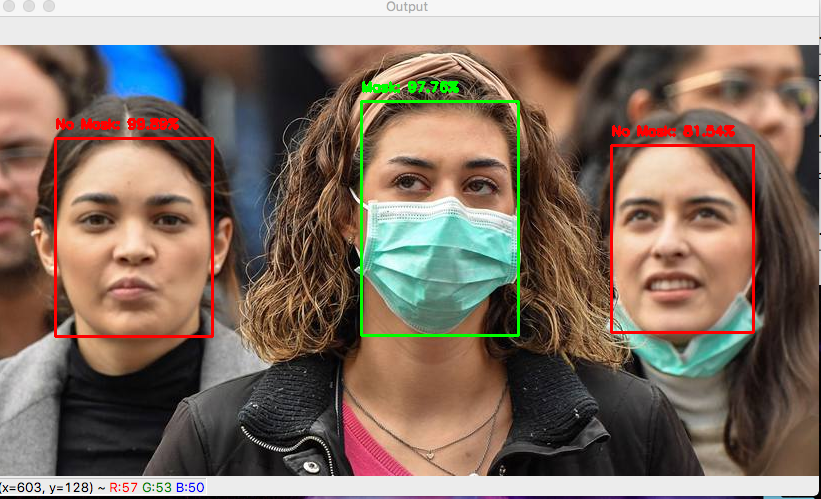

**Objective** is to build a Deep Learning model which can identify if the person is wearing a mask or not.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os

### Using haar cascade to detect faces

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001. It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images. It is then used to detect objects in other images. We'll be using a Haar Cascade Model trained to detect faces in order to obtain the bounding box coordinates of faces in an image.

In [2]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

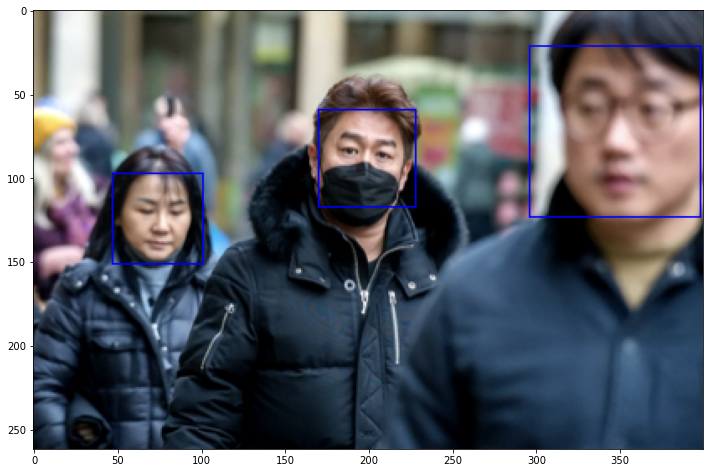

In [3]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('../input/face-mask-detection/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

### Using VGG19 for mask detection


In [4]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [5]:
#Load train and test set
train_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
test_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
val_dir = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [6]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Building VGG19 transfer learning model.

In [7]:
# transfer learning
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [8]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [9]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=len(train_generator)//32,
                              epochs=20,validation_data=val_generator,
                              validation_steps=len(val_generator)//32)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
9/9 [==============================] - 8s 491ms/step - loss: 0.8442 - accuracy: 0.5750
Epoch 2/20
9/9 [==============================] - 4s 427ms/step - loss: 0.3242 - accuracy: 0.8734
Epoch 3/20
9/9 [==============================] - 4s 415ms/step - loss: 0.2283 - accuracy: 0.9297
Epoch 4/20
9/9 [==============================] - 4s 391ms/step - loss: 0.1348 - accuracy: 0.9603
Epoch 5/20
9/9 [==============================] - 3s 375ms/step - loss: 0.1332 - accuracy: 0.9568
Epoch 6/20
9/9 [==============================] - 3s 363ms/step - loss: 0.0764 - accuracy: 0.9847
Epoch 7/20
9/9 [==============================] - 3s 358ms/step - loss: 0.1358 - accuracy: 0.9491
Epoch 8/20
9/9 [==============================] - 3s 369ms/step - loss: 0.1221 - accuracy: 0.9623
Epoch 9/20
9/9 [==============================] - 3s 359ms/step - loss: 0.1082 - accuracy: 0.9690
Epoch 10/20
9/9 [==============================] - 3s 352ms/step - loss: 0.0924 - accuracy: 0.9706
Epoch 11/20
9/9 [==

In [10]:
model.evaluate_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.05999661609530449, 0.9787499904632568]

Our model achieved 98% accuracy on test data.

### Testing the model on the test data

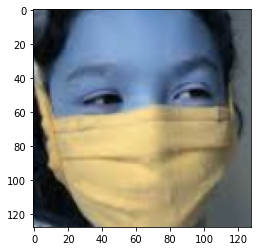

In [11]:
sample_mask_img = cv2.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/1565.png')
sample_mask_img = cv2.resize(sample_mask_img,(128,128))
plt.imshow(sample_mask_img)
sample_mask_img = np.reshape(sample_mask_img,[1,128,128,3])
sample_mask_img = sample_mask_img/255.0

In [12]:
model.predict(sample_mask_img)

array([[0.9590637 , 0.12568562]], dtype=float32)

This means that the model predicted that this person is 95.90% wearing a mask and 12.56% not wearing it, we can conclude that the person is wearing a mask then.<br>
Our model is then able to classify if the person is wearing a mask or not.

### Save the model.

In [13]:
model.save('masknet.h5')

### Integrating with haar cascade

We now take crops of the faces detected in the image and use the model trained in the above section to determine whether the individual faces have a mask or not.

In [25]:
mask_label = {0:'MASK',1:'NO MASK'}

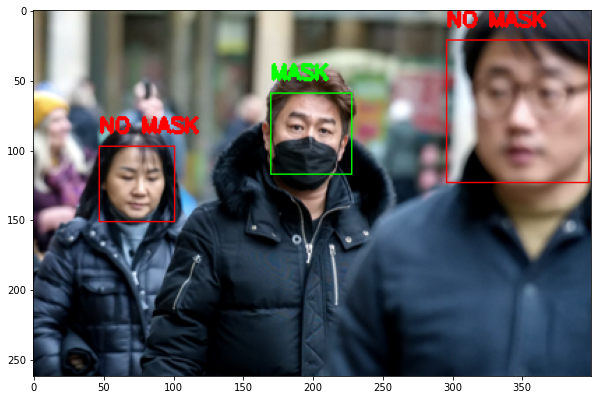

In [26]:
new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    mask_result = model.predict(crop)
    
    color = (0, 255, 0) if mask_label[mask_result.argmax()] == 'MASK' else (255, 0, 0) # green for mask, red for no mask
    
    cv2.putText(new_img, mask_label[mask_result.argmax()], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    cv2.rectangle(new_img, (x,y), (x+w,y+h), color, 1)
    
plt.figure(figsize=(10,10))
plt.imshow(new_img)